In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from redist import modifier
import knunu_utils
import ksnunu_utils

from bayesian_pyhf import plotting
import arviz as az
import corner

In [2]:
files       = ['knunu_model.json', 'ksnunu_model.json']
alt_dists   = [knunu_utils.alt_pred().distribution, ksnunu_utils.alt_pred().distribution]
null_dists  = [knunu_utils.null_pred().distribution, ksnunu_utils.null_pred().distribution]

model, data = modifier.combine(files, alt_dists, null_dists, return_data=True)
yields = data[:model.config.nmaindata]

## Load and plot samples

In [3]:
post_data = az.from_json( 'samples/comb_post_data.json')
post_pred = az.from_json( 'samples/comb_post_pred.json')
prior_pred = az.from_json('samples/comb_prior_pred.json')

In [4]:
post_data.posterior

<xarray.Dataset>
Dimensions:                      (chain: 4, draw: 100000,
                                  FFK_decorrelated[0]_dim_0: 1,
                                  FFK_decorrelated[1]_dim_0: 1,
                                  FFK_decorrelated[2]_dim_0: 1,
                                  FFK_decorrelated[3]_dim_0: 1,
                                  FFK_decorrelated[4]_dim_0: 1,
                                  ...
                                  FFKs_decorrelated[15]_dim_0: 1,
                                  FFKs_decorrelated[16]_dim_0: 1,
                                  FFKs_decorrelated[17]_dim_0: 1,
                                  FFKs_decorrelated[18]_dim_0: 1, cvl_dim_0: 1,
                                  cvr_dim_0: 1, csl_dim_0: 1, csr_dim_0: 1,
                                  ctl_dim_0: 1)
Coordinates: (12/36)
  * chain                        (chain) int64 0 1 2 3
  * draw                         (draw) int64 0 1 2 3 ... 99997 99998 99999
  * FFK_decorrelated[0]_dim_0    (FFK_decorrelated[0]_dim_0) int64 0
  * FFK_decorrelated[1]_dim_0    (FFK_decorrelated[1]_dim_0) int64 0
  * FFK_decorrelated[2]_dim_0    (FFK_decorrelated[2]_dim_0) int64 0
  * FFK_decorrelated[3]_dim_0    (FFK_decorrelated[3]_dim_0) int64 0
    ...                           ...
  * FFKs_decorrelated[18]_dim_0  (FFKs_decorrelated[18]_dim_0) int64 0
  * cvl_dim_0                    (cvl_dim_0) int64 0
  * cvr_dim_0                    (cvr_dim_0) int64 0
  * csl_dim_0                    (csl_dim_0) int64 0
  * csr_dim_0                    (csr_dim_0) int64 0
  * ctl_dim_0                    (ctl_dim_0) int64 0
Data variables: (12/34)
    FFK_decorrelated[0]          (chain, draw, FFK_decorrelated[0]_dim_0) float64 ...
    FFK_decorrelated[1]          (chain, draw, FFK_decorrelated[1]_dim_0) float64 ...
    FFK_decorrelated[2]          (chain, draw, FFK_decorrelated[2]_dim_0) float64 ...
    FFK_decorrelated[3]          (chain, draw, FFK_decorrelated[3]_dim_0) float64 ...
    FFK_decorrelated[4]          (chain, draw, FFK_decorrelated[4]_dim_0) float64 ...
    FFK_decorrelated[5]          (chain, draw, FFK_decorrelated[5]_dim_0) float64 ...
    ...                           ...
    FFKs_decorrelated[18]        (chain, draw, FFKs_decorrelated[18]_dim_0) float64 ...
    cvl                          (chain, draw, cvl_dim_0) float64 9.439 ... 7.94
    cvr                          (chain, draw, cvr_dim_0) float64 3.142 ... 4...
    csl                          (chain, draw, csl_dim_0) float64 3.319 ... 0...
    csr                          (chain, draw, csr_dim_0) float64 1.472 ... 4...
    ctl                          (chain, draw, ctl_dim_0) float64 4.818 ... 4...
Attributes:
    created_at:                 2024-01-18T19:24:45.002326
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.2
    sampling_time:              15886.979335069656
    tuning_steps:               10000

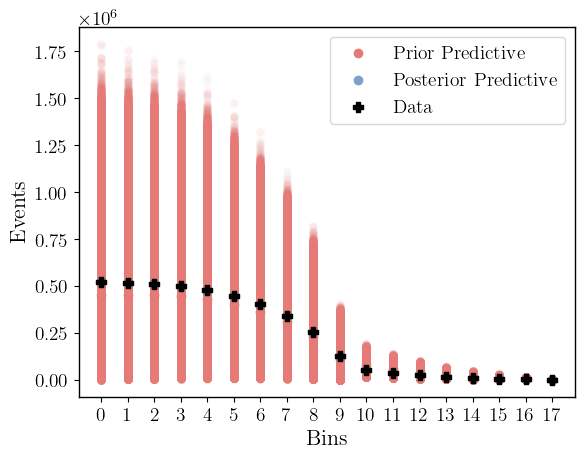

In [5]:
plotting.prior_posterior_predictives(model=model, data=yields, post_pred=post_pred, prior_pred=prior_pred)
plt.show()

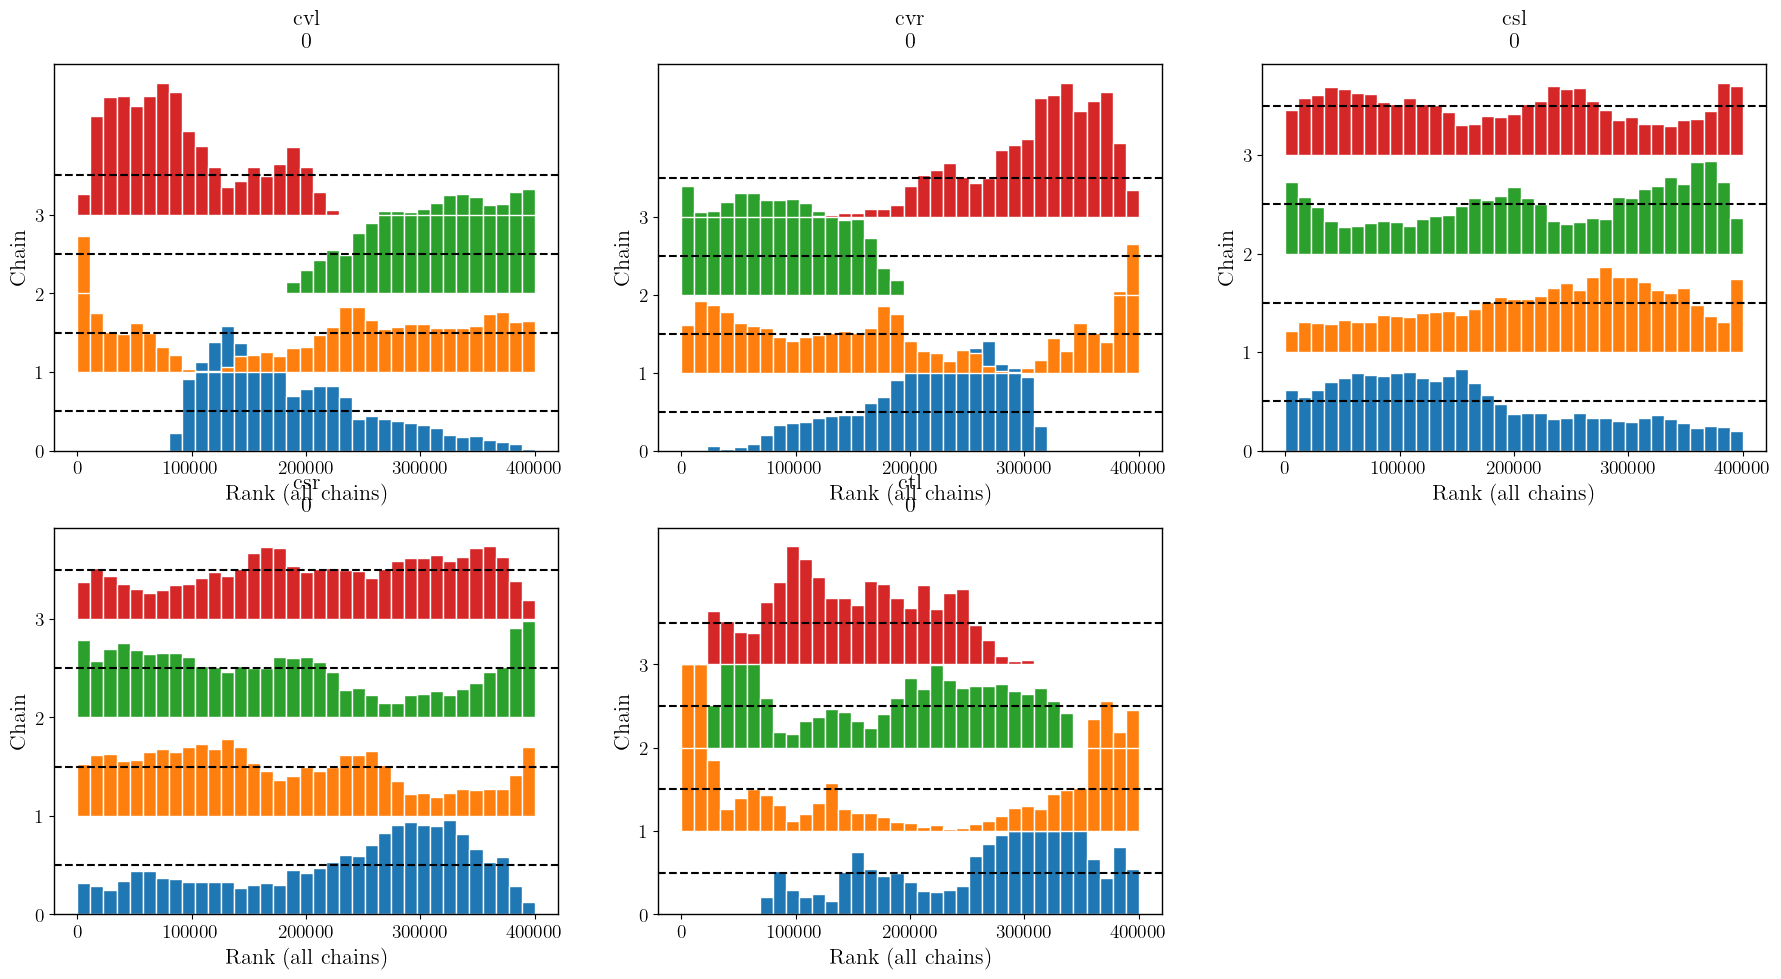

In [6]:
az.plot_rank(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl']);

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>, <Axes: title={'center': 'r_hat'}>],
      dtype=object)

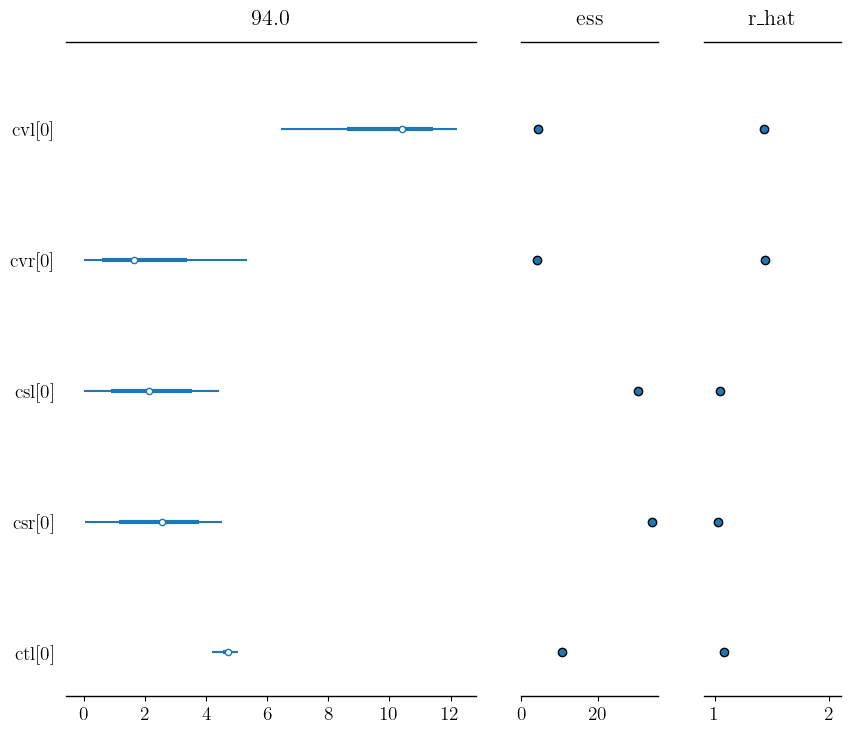

In [7]:
az.plot_forest(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'], combined=True, ess=True, r_hat=True)

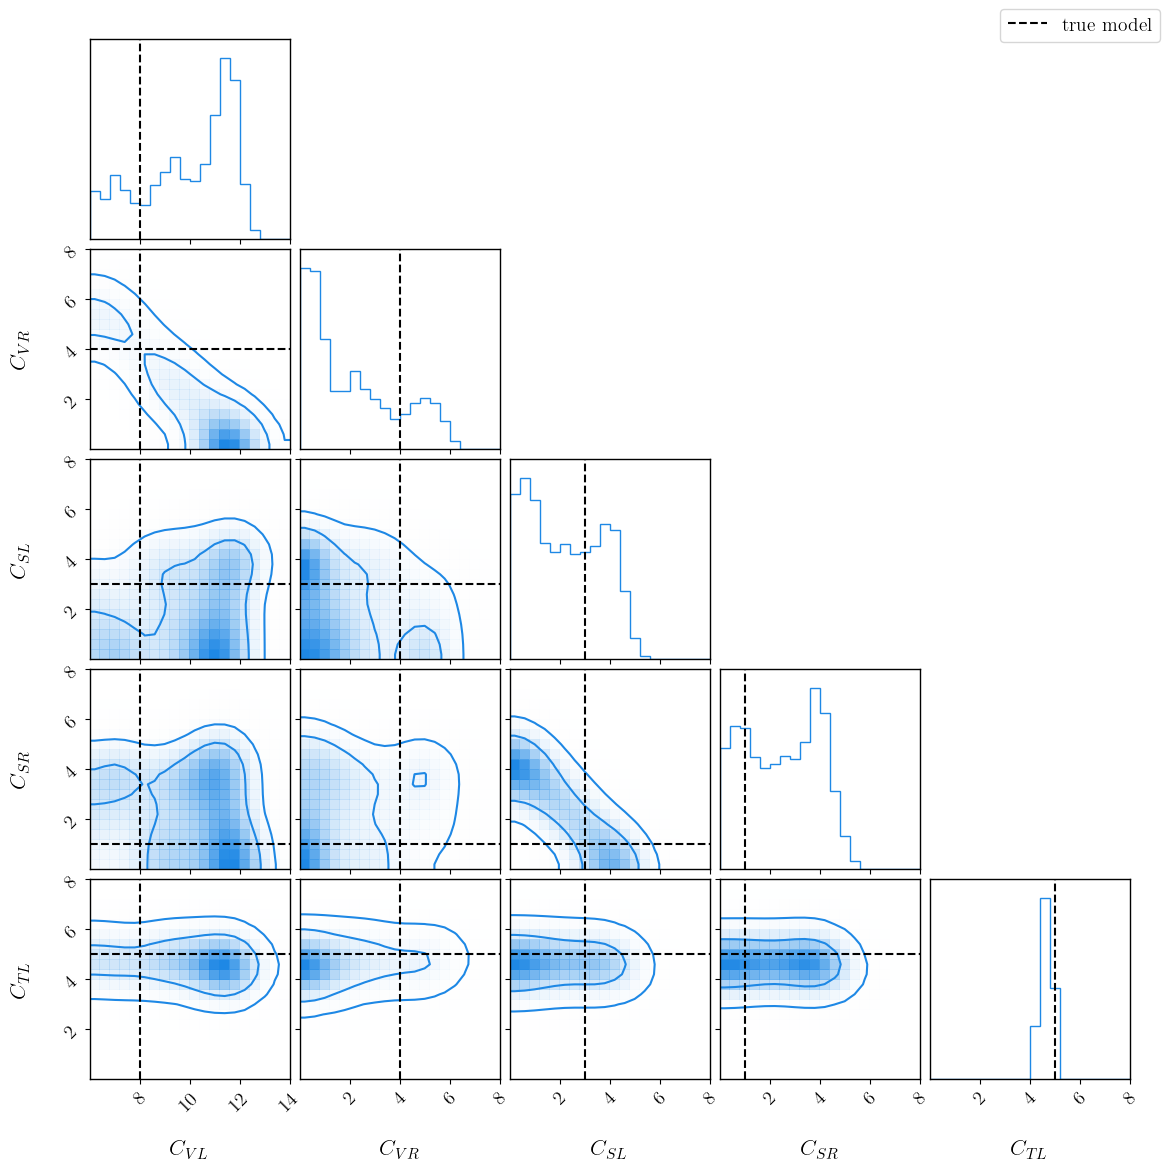

In [8]:
cvl = r'$C_{VL}$'
cvr = r'$C_{VR}$'
csl = r'$C_{SL}$'
csr = r'$C_{SR}$'
ctl = r'$C_{TL}$'
labels = [cvl, cvr, csl, csr, ctl]

file = 'results/combination_samples.pdf'

fig = corner.corner(post_data.posterior, 
                    var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'],
                    bins=20, 
                    levels=(0.68, 0.95), 
                    # quantiles=(0.025, 0.975), 
                    range = [(6, 14), (0,8),(0,8), (0,8), (0,8)],
                    smooth=2,
                    labels=labels,
                    color='#1E88E5',
                    plot_datapoints=False
                    );

truewcs = [8, 4, 3, 1, 5]
corner.overplot_lines(fig, truewcs, color='k', label='true model', linestyle='--')

handles, labs = fig.axes[0].get_legend_handles_labels()
by_label = dict(zip(labs, handles))
fig.legend(by_label.values(), by_label.keys())

plt.savefig(file)
plt.show()